In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
from torch import optim
import numpy as np
import pandas as pd
import os, time, random
import matplotlib.pyplot as plt
from utils import one_hot, resize_to_ori_calMAE, resize_to_ori
import math

C:\Users\WIN10\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Define save path

In [2]:
folder = 'election_GAN(pytorch)/'
gen_results = 'generated_results/'

model = 'model_'

if not os.path.isdir(folder):
    os.mkdir(folder)
    
if not os.path.isdir(folder + gen_results):
    os.mkdir(folder + gen_results)

# save ckpt
saver_path = os.path.join(folder, model)

# save generated data
generated_path = os.path.join(folder + gen_results)

# Load data

In [3]:
img_width = 30
img_height = 24

data_alt3 = pd.read_csv('./data/netflix_data_3alt_resize.csv')
data_alt3 = data_alt3.iloc[:1000,1:].values

data_alt3 = data_alt3.reshape([-1, img_height, img_width])
print(data_alt3.shape)

##################################
data_alt4 = pd.read_csv('./data/netflix_data_4alt_resize.csv')
data_alt4 = data_alt4.iloc[:1000,1:].values

data_alt4 = data_alt4.reshape([-1, img_height, img_width])
print(data_alt4.shape)

data_alt_3_4 = np.concatenate( (data_alt3, data_alt4), axis = 0)
print(data_alt_3_4.shape)

(1000, 24, 30)
(1000, 24, 30)
(2000, 24, 30)


In [4]:
# fig, ax = plt.subplots(figsize=(5, 5))
# ax.cla()
# ax.imshow(np.reshape(data_alt3[2], (data_alt3.shape[1], data_alt3.shape[2])), cmap='gray')

# fig, ax = plt.subplots(figsize=(5, 5))
# ax.cla()
# ax.imshow(np.reshape(data_alt4[99], (data_alt3.shape[1], data_alt3.shape[2])), cmap='gray')

In [5]:
label_alt3 = np.zeros([data_alt3.shape[0]])
label_alt4 = np.zeros([data_alt4.shape[0]]) + 1
label_alt_3_4 = np.concatenate( (label_alt3,label_alt4), axis = 0)

label_alt_onehot = one_hot(label_alt_3_4, 1 + 1)   
print(label_alt_onehot.shape)

(2000, 2)


# resize the data into original shape

In [6]:
data_alt3_ori = resize_to_ori_calMAE(data_alt3, np.math.factorial(6), img_width, img_height, np.math.factorial(3))
print('data_alt3_ori: ', data_alt3_ori.shape)

data_alt4_ori = resize_to_ori_calMAE(data_alt4, np.math.factorial(6), img_width, img_height, np.math.factorial(4))
print('data_alt4_ori: ', data_alt4_ori.shape)

data_alt3_ori:  (1000, 6)
data_alt4_ori:  (1000, 24)


# cal MAE_train_train

In [7]:
MAE_train_train_alt3 = []
MAE_train_train_alt4 = []
for i in range(len(data_alt3_ori)):
    for j in range(len(data_alt3_ori)):
        MAE_train_train_alt3.append(np.mean(np.abs(data_alt3_ori[i] - data_alt3_ori[j])))     
        MAE_train_train_alt4.append(np.mean(np.abs(data_alt4_ori[i] - data_alt4_ori[j])))    
        
MAE_train_train_alt3 = np.array(MAE_train_train_alt3)
MAE_train_train_alt4 = np.array(MAE_train_train_alt4)
print(MAE_train_train_alt3.shape)
print(MAE_train_train_alt4.shape)

MAE_train_train_alt3_mean = np.mean(MAE_train_train_alt3)
MAE_train_train_alt4_mean = np.mean(MAE_train_train_alt4)
print(MAE_train_train_alt3_mean)
print(MAE_train_train_alt4_mean)

(1000000,)
(1000000,)
0.14297275102413617
0.041658739360209994


# Define Generator and discriminator

In [8]:
def gradient_penalty(dis, x_real, x_fake, x_label, device="cpu"):
    batch_size, height, width = x_real.shape
    alpha = torch.rand((batch_size, 1, 1)).repeat(1, height, width).to(device)
    interpolated_images = x_real * alpha + x_fake * (1 - alpha)

    # Calculate dis scores
    mixed_scores = dis(interpolated_images, x_label)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [9]:
class Generator(nn.Module):
    def __init__(self, z_dim = 128, num_classes = 2):
        super(Generator, self).__init__()
        self.dim = 128
        self.hidden = torch.nn.Linear(z_dim + num_classes, self.dim*1*1*3)   
        self.tconv1 = self.conv_block(self.dim*3, self.dim*3, k_size=[1,5], stride=[1,5], pad=0, out_pad=0, use_bn=False)
        self.tconv2 = self.conv_block(self.dim*3, self.dim*2, k_size=[4,1], stride=[4,1], pad=0, out_pad=0, use_bn=False)
        self.tconv3 = self.conv_block(self.dim*2, self.dim*1, k_size=[3,3], stride=[3,3], pad=0, out_pad=0, use_bn=False)
        self.tconv4 = self.conv_block(self.dim*1, 1, k_size=[2,2], stride=[2,2], pad=0, out_pad=0, use_bn=False)        
        
    def conv_block(self, c_in, c_out, k_size, stride, pad, out_pad, use_bn=False):
        module = []
        module.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, padding=pad, output_padding=out_pad, bias=not use_bn))
        if use_bn: module.append(nn.BatchNorm2d(c_out))
        return nn.Sequential(*module)        

    def forward(self, x, label):
        x = x.reshape([x.shape[0], -1, 1, 1])
        label = label.reshape([x.shape[0], -1, 1, 1])
        x = torch.cat((x, label), dim=1).reshape([x.shape[0], -1])
        x = F.relu(self.hidden(x)).reshape([x.shape[0], 3*self.dim, 1, 1])
        x = F.relu(self.tconv1(x))
        x = F.relu(self.tconv2(x))
        x = self.tconv3(x)
        x = self.tconv4(x)
        
        return x.squeeze()

In [10]:
'''padding: same'''

class Conv2dSame(torch.nn.Conv2d):

    def calc_same_pad(self, i: int, k: int, s: int, d: int) -> int:
        return max((math.ceil(i / s) - 1) * s + (k - 1) * d + 1 - i, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        ih, iw = x.size()[-2:]

        pad_h = self.calc_same_pad(i=ih, k=self.kernel_size[0], s=self.stride[0], d=self.dilation[0])
        pad_w = self.calc_same_pad(i=iw, k=self.kernel_size[1], s=self.stride[1], d=self.dilation[1])

        if pad_h > 0 or pad_w > 0:
            x = F.pad(
                x, [pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2]
            )
        return F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)
    
class Discriminator(nn.Module):
    def __init__(self, num_classes = 2):
        super(Discriminator, self).__init__()
        self.dim = 128
        self.height = 24
        self.width = 30
        self.conv1 = self.conv_block(1 + num_classes, self.dim, k_size=[4,5], stride=[2,2], pad=0)
        self.conv2 = self.conv_block(self.dim, self.dim * 2, k_size=[4,5], stride=[2,2], pad=0)
        self.conv3 = self.conv_block(self.dim * 2, self.dim * 2, k_size=[4,5], stride=[2,2], pad=0)
        self.hidden = torch.nn.Linear(3072, 1)  

    def conv_block(self, c_in, c_out, k_size, stride, pad=0, use_bn=False):
        module = []
        module.append(Conv2dSame(in_channels=c_in, 
                                 out_channels=c_out, kernel_size=k_size, stride=stride, groups=1, bias=not use_bn))
        if use_bn: module.append(nn.BatchNorm2d(c_out))
        return nn.Sequential(*module)        
        
    def forward(self, x, label):
        alpha = 0.2
        x = x.reshape([batch_size, 1, self.height, self.width])
        label = label.reshape([batch_size, 2, self.height, self.width])
        x = torch.cat((x, label), dim=1)
        x = F.leaky_relu(self.conv1(x), alpha)
        x = F.leaky_relu(self.conv2(x), alpha)
        x = self.conv3(x)
        x = x.reshape([x.shape[0], -1])
        x = self.hidden(x)
                        
        return x.squeeze()

In [11]:
class election_GAN(object):
    def __init__(self,
                num_samples = None,
                dim_height = None,
                dim_width = None,
                dim_z = None,
                num_class = None,
                batch_size = None,
                lambda_gp = None):
        
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
#         self.device = "cpu" 
        self.num_samples = num_samples
        self.dim_height = dim_height
        self.dim_width = dim_width
        self.dim_z = dim_z
        self.num_class = num_class
        self.batch_size = batch_size
        self.lambda_gp = lambda_gp
       
    '''loss curve'''
    def show_train_hist(self):
        x = range(len(self.train_hist['D_losses']))

        y1 = self.train_hist['D_losses']
        y2 = self.train_hist['G_losses']

        plt.plot(x, y1, label='D_loss')
        plt.plot(x, y2, label='G_loss')

        plt.xlabel('Epoch')
        plt.ylabel('Loss')

        plt.legend(loc=4)  
        plt.grid(True)
        plt.tight_layout() 
        plt.title("Training Losses")

        plt.show()  
        
    def resize_to_ori_calMAE(self, x, img_size, ori_size):
        cell_size = int(img_size//ori_size)

        ori_dat = []
        for j in range(len(x)):
            dat = x[j].reshape([self.dim_height*self.dim_width])
            tmp = []
            for i in range(dat.shape[0] // cell_size):
                tmp.append(torch.mean(dat[(i)*cell_size:(i+1)*cell_size]))
            ori_dat.append(tmp)
        return torch.Tensor(ori_dat).to(self.device)   
    
    def cal_penalty(self, x_fake, y_all, data_alt3_ori, data_alt4_ori, MAE_train_train_alt3_mean, MAE_train_train_alt4_mean):
        
        x_fake_alt3, x_fake_alt4 = [], []
        for i in range(self.batch_size):
            if y_all[i] == 0: x_fake_alt3.append(x_fake[i])
            else: x_fake_alt4.append(x_fake[i])

        random_seed = np.random.randint(len(data_alt3_ori), size = self.batch_size)
        data_alt3_ori_UniformSampling = data_alt3_ori[random_seed]
        data_alt4_ori_UniformSampling = data_alt4_ori[random_seed]
        
        data_alt3_ori_UniformSampling = torch.Tensor(data_alt3_ori_UniformSampling).to(self.device)    
        data_alt4_ori_UniformSampling = torch.Tensor(data_alt4_ori_UniformSampling).to(self.device)  
        
        x_fake_alt3 = self.resize_to_ori_calMAE(x_fake_alt3, np.math.factorial(6), np.math.factorial(3))
        x_fake_alt4 = self.resize_to_ori_calMAE(x_fake_alt4, np.math.factorial(6), np.math.factorial(4))

        MAE_train_gen_alt3, MAE_train_gen_alt4 = [], []
        for i in range(int(self.batch_size)):
            for j in range(int(self.batch_size//2)):
                MAE_train_gen_alt3.append(torch.mean(torch.abs(data_alt3_ori_UniformSampling[i] - x_fake_alt3[j])))   
                MAE_train_gen_alt4.append(torch.mean(torch.abs(data_alt4_ori_UniformSampling[i] - x_fake_alt4[j])))                                 

        MAE_train_gen_alt3 = torch.Tensor(MAE_train_gen_alt3)#.to(self.device)  
        MAE_train_gen_alt4 = torch.Tensor(MAE_train_gen_alt4)#.to(self.device)   
        
        delta_MAE_alt3_mean = torch.abs(torch.mean(MAE_train_gen_alt3) - MAE_train_train_alt3_mean)
        delta_MAE_alt4_mean = torch.abs(torch.mean(MAE_train_gen_alt4) - MAE_train_train_alt4_mean)        
        delta_MAE_mean = delta_MAE_alt3_mean + delta_MAE_alt4_mean
        MAE_std = torch.std(MAE_train_gen_alt3) + torch.std(MAE_train_gen_alt4)
        MAE_max = torch.max(MAE_train_gen_alt3) + torch.max(MAE_train_gen_alt4)
        MAE_min = torch.min(MAE_train_gen_alt3) + torch.min(MAE_train_gen_alt4) 
        
        return delta_MAE_mean, MAE_std, MAE_max, MAE_min
    
    def train_model(self,
                    x_train = None,     
                    y_train = None,
                    dataloder_num_workers = 1,
                    train_epoch = 17000, 
                    step_valid = 50,
                    step_save_data = 1000,
                    iteration_generator = None,
                    n_critic = 5,
                    data_alt3_ori = None,
                    data_alt4_ori = None,
                    MAE_train_train_alt3_mean = None,
                    MAE_train_train_alt4_mean = None,
                   ):
        '''define gen, dis and optim'''
        self.gen = Generator(z_dim = self.dim_z, num_classes = self.num_class).to(self.device)
        self.dis = Discriminator(num_classes = self.num_class).to(self.device)

        self.g_opt = optim.Adam(self.gen.parameters(), lr=0.0001, betas=(0.5, 0.9))
        self.d_opt = optim.Adam(self.dis.parameters(), lr=0.0001, betas=(0.5, 0.9))
        
        '''load data into dataloder'''
        torch_dataset = Data.TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))

        data_loader = Data.DataLoader(dataset = torch_dataset, batch_size = self.batch_size, 
                                shuffle = True, num_workers = dataloder_num_workers, drop_last = True)
        
        
        ''' Training '''
        self.train_hist = {}
        self.train_hist['D_losses'] = []
        self.train_hist['G_losses'] = []

        time_start=time.time()

        print('Optimization start!')
        for epoch in range(train_epoch):
            G_losses = []
            D_losses = []

            time_start_epoch = time.time()

            for i, data in enumerate(data_loader):
                x_real, x_label = data        
                x_real = x_real.to(self.device)


                z_label = x_label.reshape([self.batch_size, self.num_class, 1, 1]).to(self.device)
                np_ones = np.ones([self.batch_size, self.num_class, self.dim_height, self.dim_width])
                x_label = z_label * torch.Tensor(np_ones).to(self.device)

                '''#############        Discriminator       #######################'''
                z_fake = torch.randn(self.batch_size, self.dim_z, 1, 1).to(self.device)
                x_fake = self.gen(z_fake, z_label)
                fake_out = self.dis(x_fake.detach(), x_label)
                real_out = self.dis(x_real.detach(), x_label)
                gp = gradient_penalty(self.dis, x_real, x_fake, x_label, device = self.device)
                self.d_loss = (-(torch.mean(real_out) - torch.mean(fake_out)) + self.lambda_gp * gp)

                self.dis.zero_grad()
                self.d_loss.backward()
                self.d_opt.step()  
                D_losses.append(self.d_loss.data.cpu().numpy())

                '''#############        Generator          #######################'''
                if (i+1) % n_critic == 0:  
                    z_fake = torch.randn(self.batch_size, self.dim_z, 1, 1).to(self.device)
                    
                    ### create label 
                    y_alt3 = np.zeros([int(self.batch_size//2), 1]) + 0
                    y_alt4 = np.zeros([int(self.batch_size//2), 1]) + 1
                    y_all = np.concatenate((y_alt3, y_alt4), axis=0).reshape([-1])
                    np.random.seed(0)
                    np.random.shuffle(y_all)
                    z_label = one_hot(y_all, self.num_class).reshape([self.batch_size, self.num_class, 1, 1])
                    x_label = z_label * np.ones([self.batch_size, self.num_class, self.dim_height, self.dim_width])
                    z_label = torch.Tensor(z_label).to(self.device)    
                    x_label = torch.Tensor(x_label).to(self.device)    
                    
                    x_fake = self.gen(z_fake, z_label)
                    fake_out = self.dis(x_fake, x_label)
                
                    if epoch > 2000: 
                        delta_MAE_mean, MAE_std, MAE_max, MAE_min = self.cal_penalty(x_fake, y_all, 
                                    data_alt3_ori, data_alt4_ori, MAE_train_train_alt3_mean, MAE_train_train_alt4_mean)

                        self.g_loss = -torch.mean(fake_out) + delta_MAE_mean + 3*MAE_std + MAE_max + -(MAE_min)
                        
                    else: self.g_loss = -torch.mean(fake_out)                    
                                        
                    self.g_opt.zero_grad()
                    self.g_loss.backward()
                    self.g_opt.step()
                    G_losses.append(self.g_loss.data.cpu().numpy())


            ############        show loss      #######################
            if (epoch+1) % 1 == 0:
                print('[%d/%d] loss_d: %.3f, loss_g: %.3f'%((epoch + 1), train_epoch, np.mean(D_losses), np.mean(G_losses)))
                self.train_hist['D_losses'].append(np.mean(D_losses))
                self.train_hist['G_losses'].append(np.mean(G_losses))

            ############        visualize generated data      #######################
            if (epoch+1) % step_valid == 0:
                with torch.no_grad():
                   ############        num_alternative = 3      #######################
                    z_fake = torch.randn(self.batch_size, self.dim_z, 1, 1).to(self.device)
                    z_label = np.zeros([self.batch_size, 1]) + 0
                    z_label = one_hot(z_label, self.num_class).reshape([self.batch_size, self.num_class, 1, 1])
                    z_label = torch.Tensor(z_label).to(self.device)    

                    gen_alt3 = self.gen(z_fake, z_label)
                    ############        num_alternative = 4      #######################
                    z_fake = torch.randn(self.batch_size, self.dim_z, 1, 1).to(self.device)
                    z_label = np.zeros([self.batch_size, 1]) + 1
                    z_label = one_hot(z_label, self.num_class).reshape([self.batch_size, self.num_class, 1, 1])
                    z_label = torch.Tensor(z_label).to(self.device)    

                    gen_alt4 = self.gen(z_fake, z_label)

                    plt.figure(epoch)
                    fig, ax = plt.subplots(figsize=(3, 3))
                    ax.cla()
                    ax.imshow(gen_alt3.data.cpu().numpy()[0], cmap='gray')

                    fig, ax = plt.subplots(figsize=(3, 3))
                    ax.cla()
                    ax.imshow(gen_alt4.data.cpu().numpy()[0], cmap='gray')            
                    plt.show()      

            ############        save per 1000 epoch      #######################
            if (epoch+1) % step_save_data == 0:
                with torch.no_grad():

                    generated_3alt = []
                    generated_4alt = []                     
                    for _ in range(iteration_generator):  
                       ############        num_alternative = 3      #######################
                        z_fake = torch.randn(self.batch_size, self.dim_z, 1, 1).to(self.device)
                        z_label = np.zeros([self.batch_size, 1]) + 0
                        z_label = one_hot(z_label, self.num_class).reshape([self.batch_size, self.num_class, 1, 1])
                        z_label = torch.Tensor(z_label).to(self.device)    
                        gen_alt3 = self.gen(z_fake, z_label)
                        generated_3alt.append(gen_alt3.data.cpu().numpy().reshape([self.batch_size, self.dim_height, self.dim_width]))

                        ############        num_alternative = 4      #######################
                        z_fake = torch.randn(self.batch_size, self.dim_z, 1, 1).to(self.device)
                        z_label = np.zeros([self.batch_size, 1]) + 1
                        z_label = one_hot(z_label, self.num_class).reshape([self.batch_size, self.num_class, 1, 1])
                        z_label = torch.Tensor(z_label).to(self.device)    
                        gen_alt4 = self.gen(z_fake, z_label)
                        generated_4alt.append(gen_alt4.data.cpu().numpy().reshape([self.batch_size, self.dim_height, self.dim_width]))

                    generated_3alt = np.array(generated_3alt).reshape([iteration_generator*self.batch_size, self.dim_height, self.dim_width])
                    gen_alt3_ori = resize_to_ori(generated_3alt, np.math.factorial(6), 30, 24, np.math.factorial(3), self.batch_size, iteration_generator)
                    gen_alt3_pd = pd.DataFrame(gen_alt3_ori, columns = ['ABC', 'ACB', 'BAC', 'BCA', 'CAB', 'CBA'])
                    gen_alt3_pd.to_csv(generated_path + 'generated_atl3_' + str(epoch) + '.csv')                    

                    generated_4alt = np.array(generated_4alt).reshape([iteration_generator*self.batch_size, self.dim_height, self.dim_width])     
                    gen_alt4_ori = resize_to_ori(generated_4alt, np.math.factorial(6), 30, 24, np.math.factorial(4), self.batch_size, iteration_generator)
                    gen_alt4_pd = pd.DataFrame(gen_alt4_ori, columns = ['ABCD', 'ACBD', 'BACD', 'BCAD', 'CABD', 'CBAD', 'DABC',
                           'DACB', 'DBAC', 'DBCA', 'DCAB', 'DCBA', 'ADBC', 'ADCB', 'BDAC', 'BDCA',
                           'CDAB', 'CDBA', 'ABDC', 'ACDB', 'BADC', 'BCDA', 'CADB', 'CBDA'])
                    gen_alt4_pd.to_csv(generated_path + 'generated_atl4_' + str(epoch) + '.csv')   

            time_end_epoch = time.time()
            print('Time cost in one epoch', time_end_epoch - time_start_epoch,'s')         

        ###########        save      #######################
        torch.save(self.gen, saver_path + 'gen.pkl')
        torch.save(self.dis, saver_path + 'dis.pkl')
        print('save success')    


        print("Optimization Finished!")

        time_end=time.time()
        print('Total Time cost',time_end-time_start,'s')

In [12]:
batch_size = 64

model = election_GAN(
                num_samples = data_alt_3_4.shape[0],
                dim_height = data_alt_3_4.shape[1],
                dim_width = data_alt_3_4.shape[2],
                dim_z = 128,
                num_class = label_alt_onehot.shape[-1],
                batch_size = batch_size,
                lambda_gp = 10)

In [15]:
model.train_model(
    x_train = data_alt_3_4,     
    y_train = label_alt_onehot,     
    dataloder_num_workers = 1,
    train_epoch = 3,  #17000
    step_valid = 1, #50
    step_save_data = 1000, #1000
    iteration_generator = (2000//batch_size) + 1, # 2000 samples 
    n_critic = 5, #5
    data_alt3_ori = data_alt3_ori,
    data_alt4_ori = data_alt4_ori,
    MAE_train_train_alt3_mean = MAE_train_train_alt3_mean,
    MAE_train_train_alt4_mean = MAE_train_train_alt4_mean,
    )

Optimization start!


RuntimeError: CUDA error: CUBLAS_STATUS_NOT_INITIALIZED when calling `cublasCreate(handle)`

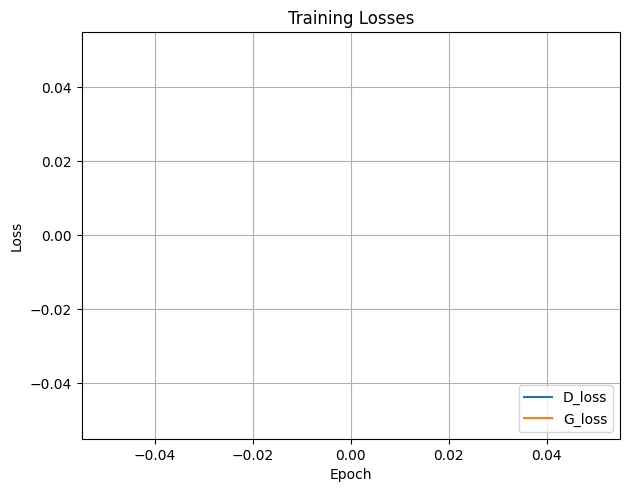

In [14]:
model.show_train_hist()

In [ ]:
torch.cuda.empty_cache()

# Show generated data

In [ ]:
# gen_trained = torch.load(saver_path + 'gen.pkl')

# ############        num_alternative = 3      #######################
# z_fake = torch.randn(batch_size, dim_z, 1, 1).to(device)
# z_label = np.zeros([batch_size, 1]) + 0
# z_label = one_hot(z_label, num_class).reshape([batch_size, num_class, 1, 1])
# z_label = torch.Tensor(z_label).to(device)    

# gen_alt3 = gen_trained(z_fake, z_label)
# ############        num_alternative = 4      #######################
# z_fake = torch.randn(batch_size, dim_z, 1, 1).to(device)
# z_label = np.zeros([batch_size, 1]) + 1
# z_label = one_hot(z_label, num_class).reshape([batch_size, num_class, 1, 1])
# z_label = torch.Tensor(z_label).to(device)    

# gen_alt4 = gen_trained(z_fake, z_label)

# plt.figure(epoch)
# fig, ax = plt.subplots(figsize=(3, 3))
# ax.cla()
# ax.imshow(gen_alt3.data.cpu().numpy()[0], cmap='gray')

# fig, ax = plt.subplots(figsize=(3, 3))
# ax.cla()
# ax.imshow(gen_alt4.data.cpu().numpy()[0], cmap='gray')            
# plt.show()